# Cell types Data Tutorial

____________

In this tutorial we will see how to use data and models from the [Neocortical Microcircuit Collaboration Portal](https://bbp.epfl.ch/nmc-portal/) (NMC)
____________


Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Werner Van Geit @ Blue Brain Project
___
### Overview:

* Electrophysiological features will be extracted from the traces, thanks to the ** Electrophys Feature Extraction Library ** [eFEL](https://github.com/BlueBrain/eFEL).

* We will also show how to generate a visualisation of a morphology on your computer using ** Neuronal Morphology Analysis Tool ** [NeuroM](https://github.com/BlueBrain/NeuroM).

* In a next exercise we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/) and to constrain the model parameters.
____

You can run this tutorial on your computer, for installation instruction, look [here](https://github.com/BlueBrain/SimulationTutorials/tree/master/General/Installation)
___

We first import some useful Python modules.

In [2]:
%load_ext autoreload
%autoreload

import numpy, IPython
import json

import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 10

import collections

from json2html import *

# 1. Electrophysiology data
In this section we will process the electrophysiological data recorded from a Layer 5 Pyramidal cell in the somatosensory cortex.

For this example we have chosen to use one negative current step and two positive current steps with different amplitudes. 

We store the data in a Python dictionary.

In [19]:
# Define the directory containing the voltage traces
data_dir = 'data/'

# Store data in a dictionary step_name : [list of repetitions]
#steps_dict = collections.OrderedDict(sorted({'StepNeg':23,'StepPos':36}.items(), key = lambda x:x[0]))
steps_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Import the os Python module to interact with the operating system
from glob import glob

files_list = glob(data_dir + "*.txt")

for file_name in files_list:
    if "APWaveform" in file_name:
        steps_dict['ShortStepPos'].append(numpy.loadtxt(file_name))
    if "IDrest" in file_name:
        steps_dict['LongStepPos'].append(numpy.loadtxt(file_name))
    if "IV" in file_name:
        steps_dict['LongStepNeg'].append(numpy.loadtxt(file_name))

We can now plot these data.

<IPython.core.display.Javascript object>


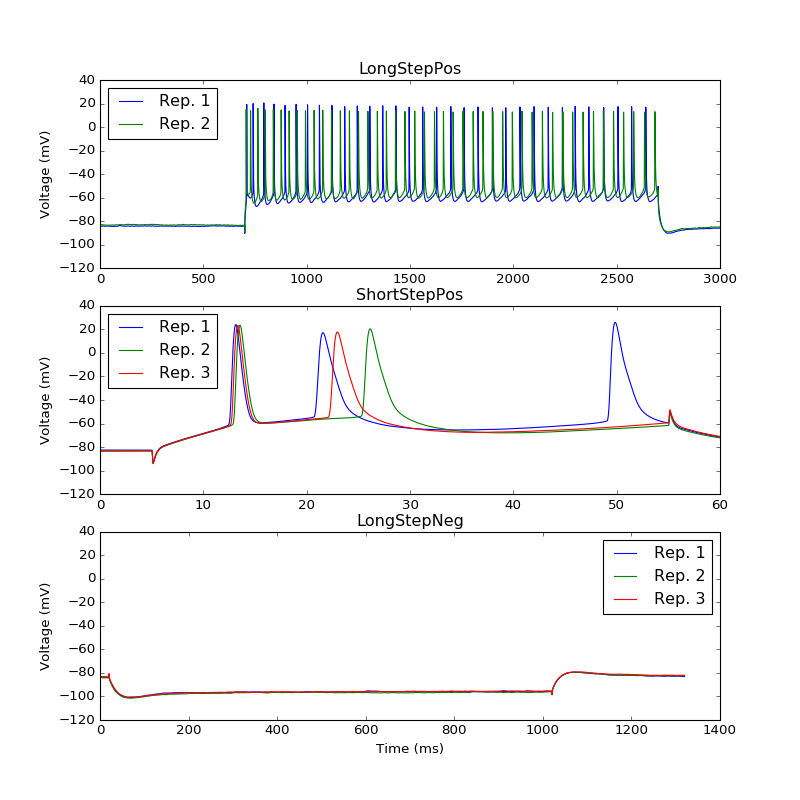

In [20]:
fig1, axes = plt.subplots(len(steps_dict), sharey = True)

for idx, step_name in enumerate(steps_dict.keys()):
    for rep, trace in enumerate(steps_dict[step_name]):
        axes[idx].plot(trace[:,0],trace[:,1]-14, label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Voltage (mV)')
        axes[idx].legend(loc = 'best')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')

# 2. Electrophysiological features
To build a detailed neuron model, we need to quantify the electrical behavior we want to reproduce. The metrics we use are the eFeatures, that measure parameters describing for instance the shape of the action potential or the firing properties of a neuron (for examples, see [here](http://bluebrain.github.io/eFEL/eFeatures.html)).

In this particular example, we extract distinct features from the three types of voltage traces.
The eFeatures extracted from the data and later from the model will be used to evaluate the results of the simulations. The mean features values, along with the standard deviations will be stored in a .json file.

In [21]:
# Extract features
import efel

# Define stimulus start and end times
steps_info = {'LongStepNeg': [20, 1020], 'ShortStepPos': [5, 55], 'LongStepPos': [700, 2700]}

def get_features(data):    
    efel_traces = {'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:
            trace = {}
            trace['T'] = rep[:,0]
            trace['V'] = rep[:,1]-14
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    features_values['LongStepNeg'] = efel.getMeanFeatureValues(efel_traces['LongStepNeg'], ['time_constant', 
                                                                                            'voltage_base',
                                                                    'voltage_deflection_begin', 'voltage_deflection'])
    features_values['LongStepPos'] = efel.getMeanFeatureValues(efel_traces['LongStepPos'], ['mean_frequency', 'adaptation_index2', 'ISI_CV', 
                                                                'doublet_ISI'])
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], ['time_to_first_spike', 
                                                                                      'AHP_depth', 
                                                                                     'AP_width', 'AP_height'])    

    return features_values

We can now visualise the feature values we computed, each row in the table corresponds to a repetition of the same step.

In [22]:
efel_features = dict(get_features(steps_dict))
IPython.display.HTML(json2html.convert(json=efel_features))

We compute features mean and standard deviation.

In [23]:
features_dict = collections.OrderedDict()
for step_name, reps in efel_features.items():
    feature_values = collections.defaultdict(list)
    for rep in reps: 
        for feature_name, value in rep.iteritems():
            feature_values[feature_name].append(value)
   
    features_dict[step_name] = {"soma":{}}
    for name, values in feature_values.items():
        features_dict[step_name]["soma"][name] = [numpy.mean(values), numpy.std(values)]
        
IPython.display.HTML(json2html.convert(json=dict(features_dict)))

We write the eFeatures in a json file that we will use later in the exercise.

In [8]:
with open('../../exercise/config/features.json', 'w') as fp:
    json.dump(features_dict, fp, indent = 4)

# 3. NMC portal neuron model

This portal provides an online public resource of the Blue Brain Project's first release of a **digital reconstruction of the microcircuitry** of juvenile Rat somatosensory cortex, access to experimental data sets used in the reconstruction, and the resulting models.

From the NMC portal we can download e.g. a model of a [Layer 5 Thick Tufted Pyramidal cell](https://bbp.epfl.ch/nmc-portal/microcircuit#/metype/L5_TTPC2_cADpyr/details).

With the command below, we can download a model from the portal.

In [13]:
!curl -o L5_TTPC2.zip https://bbp.epfl.ch/nmc-portal/documents/10184/1921755/L5_TTPC2_cADpyr232_1.zip/a058fc9c-6c67-417b-a65b-20742902ccbb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1718k    0 1718k    0     0  1339k      0 --:--:--  0:00:01 --:--:-- 1338k


In [15]:
!unzip -f L5_TTPC2.zip

Archive:  L5_TTPC2.zip


With this model we can for example create a visualisation the morphology.

<IPython.core.display.Javascript object>


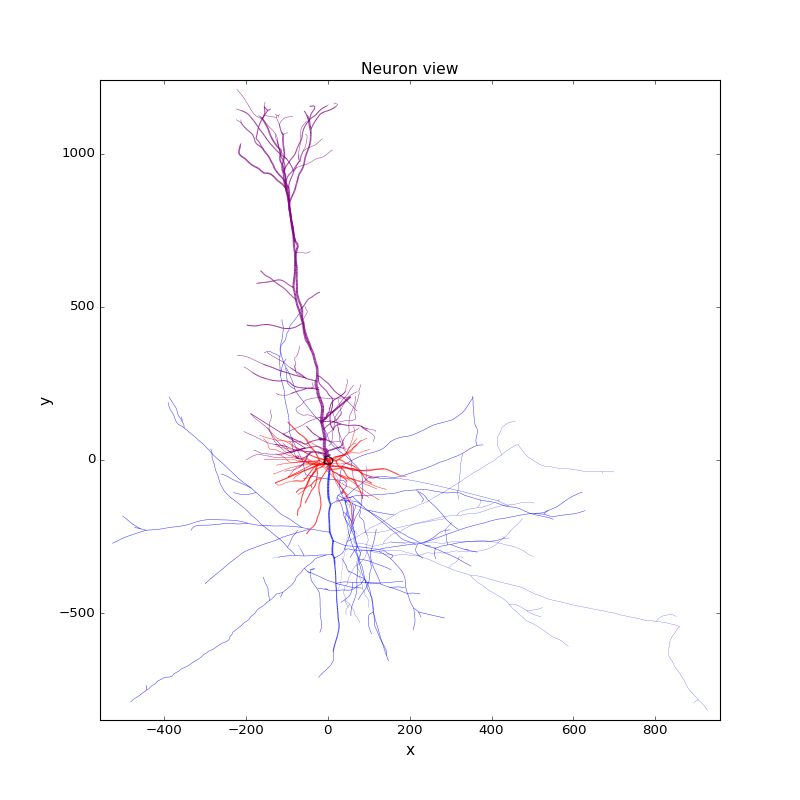

(<matplotlib.figure.Figure at 0x10b1a5ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b1a5590>)

In [24]:
from neurom import viewer, fst

morphology_file = 'L5_TTPC2_cADpyr232_1/morphology/dend-C060114A7_axon-C060116A3_-_Clone_2.asc'
nrn = fst.load_neuron(morphology_file)
viewer.draw(nrn)